# Building a language model

Here we'll be loading the cleaned text and doing some statistical analysis. Afterwards, we will build a set of word vectors from the cleaned corpus.

In [1]:
import os, re
import taumahi
import pickle
import warnings
import itertools as it
from collections import Counter
from umap import UMAP
from multiprocessing import cpu_count

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
from_scratch = False

In [3]:
te_ara_māori_sents_file = "../data/te_ara_māori_sents.txt"
with open(te_ara_māori_sents_file, "r") as f:
    te_ara_sents = f.read().strip().split("\n")

In [4]:
te_ara_sents[:10]

['ko te kāinga te pokapū o ngā mahi kai a te māori',
 'ko te maramataka ka tohu i te wā ki tēnā mahi ki tēnā mahi',
 'ka tauhokohoko ngā iwi i ngā kai mai i ngā māra te hī ika te mahi tuna te tāwhiti manu te kohikohi kai hoki',
 'ngā kaihōpara me te hunga tauhokohoko',
 'nō te takiwā o ngā tau ka tae ngā tīpuna o te māori ki aotearoa',
 'ko te iwi māori te whakamutunga o ngā iwi hōpara i te moananuiakiwa',
 'ka tauhokohoko ngā tīpuna o te māori ki tēnā iwi ki tēnā iwi i ngā moutere o te moananuiakiwa',
 'ko aotearoa te whenua rahi rawa i nōhia e ngā tāngata o te moananuiakiwa',
 'hāunga te pāmamao o te whenua hou taea noatia ai e te waka haere moana',
 'ngā moutere tango kai']

## N-grams

In [5]:
from nltk import ngrams
from nltk import word_tokenize

In [6]:
list(ngrams(word_tokenize("Hello there my friend"), 3))

[('Hello', 'there', 'my'), ('there', 'my', 'friend')]

In [7]:
warnings.filterwarnings('ignore')
ngram_length = 4
ngram_list = []
for text in te_ara_sents:
    sent = word_tokenize(text)
    for ngram in ngrams(sent, ngram_length):
        ngram_list.append(ngram)

## Stop words

In [8]:
def plot_word_frequencies(filepath, pattern='', num_terms=20, 
                          stop_words = taumahi.stop_words, title = ''):
    '''
    Plot the top `num_terms` words from the file at `filepath` matching `pattern`.
    Can also set the `title` as well.
    '''
    with open(filepath, "r") as f:
        file_sents = f.read().strip().split("\n")
    kupu = [kupu for sent in file_sents \
                 for kupu in sent.split(" ") \
                 if (len(pattern) == 0 or re.match(pattern, kupu)) and\
                 not kupu in stop_words]
    return (
        pd.Series(kupu)
            .value_counts()
            .head(num_terms)
            .sort_values()
            .plot(kind = 'barh', title = title))

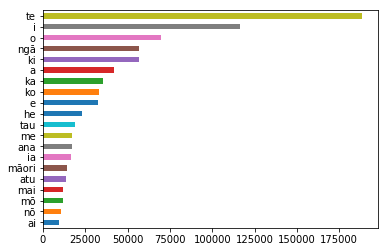

In [9]:
plot_word_frequencies('../data/trigram_sentences_all.txt', stop_words = [], num_terms=20)

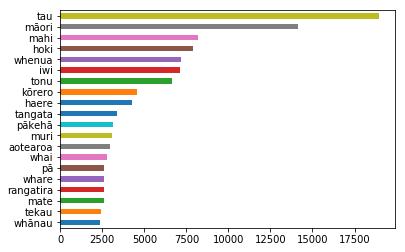

In [10]:
plot_word_frequencies('../data/trigram_sentences_all.txt', num_terms=20)

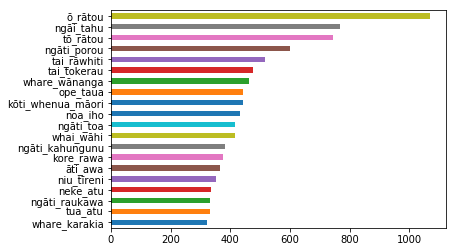

In [11]:
plot_word_frequencies('../data/trigram_sentences_all.txt', pattern="[^_]+_[^_]+_?[^_]*")

## Gensim

We will use the `gensim` library to analyse the text further.

In [12]:
from gensim.models.phrases import Phrases
from gensim.models.word2vec import LineSentence

In [13]:
unigram_sentences = LineSentence(te_ara_māori_sents_file)

In [14]:
for unigram_sentence in it.islice(unigram_sentences, 230, 240):
    print(u' '.join(unigram_sentence))
    print(u'')

ka hīia te hāpuku te kehe te maomao me te tāmure ki te wai tai ko te ūpokororo ka mahia ki te tai rāwhiti

paengawhāwhā maeheāperira

kua hauhake i ngā kai

kua rere ngā tuna heke ki roto i ngā pā tuna

kua māoa te karaka

ka tāherea te tūī me te weka ki murihiku

ka hīia te hāpuku te warehou te tāmure te ūpokororo ki te tai rāwhiti

kua mutu te mahi i te maomao

haratua āperiramei

ka hauhake i te kūmara kua houhanga



In [15]:
%%time
bigram_model_filepath = '../models/te_ara_bigrams.model'

if from_scratch or not os.path.exists(bigram_model_filepath):

    bigram_model = Phrases(unigram_sentences)

    bigram_model.save(bigram_model_filepath)
    
else:
    # load the finished model from disk
    bigram_model = Phraser.load(bigram_model_filepath)

CPU times: user 4.08 s, sys: 56.6 ms, total: 4.14 s
Wall time: 4.13 s


In [16]:
%%time
bigram_sentences_filepath = '../data/bigram_sentences_all.txt'
if from_scratch or not os.path.exists(bigram_sentences_filepath):
    
    with open(bigram_sentences_filepath, 'w') as f:    
        for unigram_sentence in unigram_sentences:
            bigram_sentence = u' '.join(bigram_model[unigram_sentence])
            f.write(bigram_sentence + '\n')

CPU times: user 9.66 s, sys: 32.3 ms, total: 9.69 s
Wall time: 9.71 s


In [17]:
bigram_sentences = LineSentence(bigram_sentences_filepath)

In [18]:
trigram_model_filepath = '../models/te_ara_trigrams.model'
trigram_sentences_filepath = '../data/trigram_sentences_all.txt'

In [19]:
if from_scratch or not os.path.exists(trigram_model_filepath):
    trigram_model = Phrases(bigram_sentences)
    trigram_model.save(trigram_model_filepath)
else:
    # load the finished model from disk
    trigram_model = Phraser.load(trigram_model_filepath)

In [20]:
for bigram_sentence in it.islice(bigram_sentences, 230, 240):
    print(' '.join(bigram_sentence))

ka hīia te hāpuku te kehe te maomao me te tāmure ki te wai tai ko te ūpokororo ka mahia ki te tai_rāwhiti
paengawhāwhā maeheāperira
kua hauhake i ngā kai
kua rere ngā tuna heke ki roto i ngā pā_tuna
kua māoa te karaka
ka tāherea te tūī me te weka ki murihiku
ka hīia te hāpuku te warehou te tāmure te ūpokororo ki te tai_rāwhiti
kua mutu te mahi i te maomao
haratua āperiramei
ka hauhake i te kūmara kua houhanga


In [21]:
%%time
if from_scratch or not os.path.exists(trigram_sentences_filepath):
    with open(trigram_sentences_filepath, 'w') as f:
        for bigram_sentence in bigram_sentences:
            trigram_sentence = u' '.join(trigram_model[bigram_sentence])
            f.write(trigram_sentence + '\n')

CPU times: user 9.43 s, sys: 55.8 ms, total: 9.49 s
Wall time: 9.5 s


In [22]:
trigram_sentences = LineSentence(trigram_sentences_filepath)

In [23]:
for trigram_sentence in it.islice(trigram_sentences, 320, 330):
    print(' '.join(trigram_sentence))
    print('')

nāwai nā te mea he makariri ake a aotearoa tērā ki ngā moutere o te moananuiakiwa ka ako te māori me pēhea te whakatipu me te tiaki i ēnei_tūmomo kai

nā ēnei mōhiotanga ka taea_noatia ai e te māori ngā ahuwhenua arumoni i tōna wā

te rīwai te poaka me te pī

nō te tōmuritanga o te rau tau atu i tae atu ki te tōmuatanga o te rau tau atu i ka taetae ngā kararehe ngā tipu me ngā taputapu rino ki aotearoa

kīhai i ārikarika te hopu a te māori ki ēnei mea hou ā taro_ake ka nui atu ngā ahuwhenua me te pāmu kararehe

i te taenga o kāpene_kuki ki aotearoa i te tau ka hoatu hoko rānei e ia he kāpeti he kotami he rīwai ki a ngāti_porou ki ūawa

i taua tau anō ka whakataka e marie he witi he raihi he pī ki taipā i te tai_tokerau

nō te tau ka hoki anō a kāpene_kuki ki aotearoa ka tau ki ūawa ka whakataka he poaka he rīwai

mai i te tau ka tīmata ngā tauhokohoko a te māori i te rīwai te poaka te kānga me ētahi atu kai

te parau me te whakapono_karaitiana



# Modelling with LDA

Now we can use Latent Dirichlet Allocation (LDA) to train a topic model.

In [24]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim
import warnings

In [25]:
trigram_dictionary_filepath = '../data/te_ara_trigrams.dict'
trigram_bow_filepath = '../models/te_ara_trigram_bow_corpus.model'

In [26]:
%%time
if from_scratch or not os.path.exists(trigram_dictionary_filepath):

    trigram_reviews = [[kupu for kupu in sent if not kupu in taumahi.stop_words] \
                             for sent in LineSentence(trigram_sentences_filepath)]

    # learn the dictionary by iterating over all of the reviews
    trigram_dictionary = Dictionary(trigram_reviews)
    
    # filter tokens that are very rare or too common from
    # the dictionary (filter_extremes) and reassign integer ids (compactify)
    trigram_dictionary.filter_extremes(no_below=10, no_above=0.4)
    trigram_dictionary.compactify()

    trigram_dictionary.save(trigram_dictionary_filepath)

else:
    # load the finished dictionary from disk
    trigram_dictionary = Dictionary.load(trigram_dictionary_filepath)

CPU times: user 2.88 s, sys: 59.1 ms, total: 2.94 s
Wall time: 2.87 s


In [27]:
def trigram_bow_generator(filepath):
    """
    generator function to read reviews from a file
    and yield a bag-of-words representation
    """
    
    for line in LineSentence(filepath):
        yield trigram_dictionary.doc2bow(line)

In [28]:
%%time
if from_scratch or not os.path.exists(trigram_bow_filepath):

    # generate bag-of-words representations for
    # all reviews and save them as a matrix
    MmCorpus.serialize(trigram_bow_filepath,
                       trigram_bow_generator(trigram_sentences_filepath))

# load the finished bag-of-words corpus from disk
trigram_bow_corpus = MmCorpus(trigram_bow_filepath)

CPU times: user 2.97 s, sys: 92 ms, total: 3.06 s
Wall time: 3.06 s


In [29]:
lda_model_filepath = '../models/te_ara_model.lda'

In [30]:
%%time
if from_scratch or not os.path.exists(lda_model_filepath):

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        # workers => sets the parallelism, and should be
        # set to your number of physical cores minus one
        lda = LdaMulticore(trigram_bow_corpus,
                           num_topics=100,
                           id2word=trigram_dictionary,
                           workers=cpu_count() - 1)
    
    lda.save(lda_model_filepath)
else:
    # load the finished LDA model from disk
    lda = LdaMulticore.load(lda_model_filepath)

CPU times: user 9.26 s, sys: 847 ms, total: 10.1 s
Wall time: 11.7 s


In [31]:
def explore_topic(topic_number, topn=10):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print('{:20} {}'.format(u'term', u'frequency') + u'\n')

    for term, frequency in lda.show_topic(topic_number, topn=topn):
        print('{:20} {:.3f}'.format(term, round(frequency, 3)))

In [32]:
explore_topic(4)

term                 frequency

mahi                 0.035
hoki                 0.025
tohutohu             0.022
tonu                 0.021
pā                   0.019
akoranga             0.018
tau                  0.017
kapa                 0.017
moriori              0.015
na                   0.014


In [33]:
LDAvis_data_filepath = '../models/prepared_model.ldavis'

In [34]:
%%time
if from_scratch or not os.path.exists(LDAvis_data_filepath):
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda, trigram_bow_corpus, trigram_dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
else:
    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)

CPU times: user 24.7 s, sys: 540 ms, total: 25.2 s
Wall time: 30.9 s


In [35]:
pyLDAvis.display(LDAvis_prepared)

## Training word vectors

Here I'll train some word vectors based on the Te Ara Corpus.

In [36]:
from gensim.models import Word2Vec

trigram_sentences = LineSentence(trigram_sentences_filepath)
word2vec_filepath = '../models/te_ara_word2vec.model'

In [37]:
def count_sentences(line_sentence):
    line_count = 0
    for line in line_sentence:
        line_count += 1
    return line_count

In [38]:
%%time
if from_scratch or not os.path.exists(word2vec_filepath):

    # initiate the model and perform the first epoch of training
    reo2vec = Word2Vec(trigram_sentences, size=100, window=5,
                        min_count=20, sg=1, workers=cpu_count()-1)

    # perform another 11 epochs of training
    reo2vec.train(
        trigram_sentences,
        total_examples = count_sentences(trigram_sentences), 
        epochs = 10)

    reo2vec.save(word2vec_filepath)
else:
    # load the finished model from disk
    reo2vec = Word2Vec.load(word2vec_filepath)
    reo2vec.init_sims()

CPU times: user 2min 15s, sys: 740 ms, total: 2min 16s
Wall time: 34.2 s


/opt/conda/lib/python3.6/site-packages/gensim/utils.py:586: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  if hasattr(self, attrib):
/opt/conda/lib/python3.6/site-packages/gensim/utils.py:587: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  asides[attrib] = getattr(self, attrib)
/opt/conda/lib/python3.6/site-packages/gensim/utils.py:588: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  delattr(self, attrib)
/opt/conda/lib/python3.6/site-packages/gensim/utils.py:543: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  setattr(obj, attrib, val)


In [39]:
reo2vec.wv.most_similar("mai")

[('atu', 0.5478876233100891),
 ('ake', 0.48823514580726624),
 ('ka', 0.4854778051376343),
 ('ki', 0.4788702726364136),
 ('i', 0.46540868282318115),
 ('whakapaparanga', 0.44860488176345825),
 ('iho', 0.4477006196975708),
 ('tata_paunga', 0.4467763304710388),
 ('aoake', 0.4465719163417816),
 ('kāti', 0.44309982657432556)]

# Visualising the word vectors

Now that we've trained a collection of word vectors, we can visualise them with the common dimensionality reduction algorithms.

In [40]:
from sklearn.manifold import TSNE

In [41]:
# build a list of the terms, integer indices,
# and term counts from the food2vec model vocabulary
ordered_vocab = [(term, reo2vec.wv.vocab[term].index, reo2vec.wv.vocab[term].count)
                 for term in reo2vec.wv.vocab]

# sort by the term counts, so the most common terms appear first
ordered_vocab = sorted(ordered_vocab, key=lambda vocab: -vocab[-1])

# unzip the terms, integer indices, and counts into separate lists
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

# create a DataFrame with the food2vec vectors as data,
# and the terms as row labels
word_vectors = pd.DataFrame(reo2vec.wv.vectors_norm[term_indices, :],
                            index=ordered_terms)

word_vectors

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
te,-0.222786,0.008506,-0.159120,0.007774,0.029601,0.056520,0.019358,-0.039438,-0.107228,0.003269,...,-0.028638,-0.091592,0.035743,-0.107965,0.040518,0.187595,-0.059293,0.013830,-0.130743,-0.051073
i,-0.178271,0.007903,-0.186632,-0.004492,0.038849,0.019271,0.047945,-0.163053,0.023553,0.117416,...,-0.059919,-0.070771,-0.080721,-0.045064,0.029262,0.025555,-0.031239,-0.108634,-0.084195,0.028562
o,-0.132126,0.090262,-0.097263,-0.045000,0.075789,0.007335,0.010829,-0.024595,0.000504,0.130633,...,-0.056956,-0.042168,-0.189204,-0.076717,0.016934,0.029308,-0.011539,0.067284,-0.026894,0.081146
ngā,-0.189056,-0.086637,-0.194186,-0.052207,-0.058781,0.073729,-0.077801,0.052055,-0.023090,0.125136,...,-0.141133,-0.162282,0.117313,-0.050744,0.013293,-0.016623,-0.127900,0.039982,-0.124890,-0.148520
ki,-0.130063,0.065038,-0.212348,-0.135235,0.047919,0.123008,-0.050220,0.027695,-0.093777,0.097687,...,-0.010310,-0.042633,-0.159101,0.077639,0.042593,0.070596,-0.065038,-0.009395,0.022219,-0.054999
a,-0.175845,0.018763,-0.096968,-0.106645,-0.072495,0.013719,0.056097,0.031060,-0.025291,0.048976,...,-0.094921,0.018158,-0.063356,-0.014329,0.099471,-0.088542,-0.028614,-0.132497,-0.024022,0.021299
ka,-0.197060,-0.092109,-0.117638,-0.089533,-0.057161,-0.068158,-0.084349,0.009953,0.054688,0.035457,...,0.145629,-0.044031,-0.098463,0.033539,-0.034774,0.034018,-0.111987,0.046354,0.178414,-0.008410
ko,-0.133083,0.051928,0.031878,0.020190,0.213817,0.000925,0.019283,0.162536,-0.077165,-0.000652,...,-0.032065,0.087359,-0.144597,0.157666,-0.074318,-0.127814,0.000023,0.089803,-0.056338,-0.021968
e,0.028727,-0.000377,-0.168198,0.033735,0.013563,0.006789,-0.023167,-0.005115,-0.073902,0.092953,...,0.003572,0.065813,-0.030391,0.053739,0.134933,-0.077564,-0.005149,-0.101293,0.103844,0.011744
he,-0.097619,0.028519,-0.140261,0.031461,0.029248,-0.102882,-0.124714,0.023364,-0.022088,-0.106683,...,-0.000419,-0.051327,0.078781,0.086448,0.002403,-0.035944,0.050018,-0.087960,-0.068596,-0.106937


In [42]:
dist_matrix = pd.DataFrame(
    np.matmul(word_vectors.values, word_vectors.values.transpose()),
    columns=word_vectors.index, index = word_vectors.index)

In [43]:
dist_matrix.head()

,te,i,o,ngā,ki,a,ka,ko,e,he,...,hinematioro,kāenga,matutaera,hemonga,kupu_whakaari,mihikitekapua,pātiti,maharaia,mātāpono_tiriti,wai_ngārahu
te,1.000000,0.628271,0.638123,0.618064,0.544520,0.433727,0.448624,0.386931,0.398505,0.445263,...,0.292715,0.267812,0.354860,0.295029,0.300009,0.217460,0.348734,0.336682,0.329291,0.153970
i,0.628271,1.000000,0.618741,0.483214,0.629857,0.537903,0.496184,0.361675,0.474900,0.289259,...,0.131130,0.340617,0.370729,0.363631,0.365941,0.247887,0.360679,0.319115,0.346018,0.099930
o,0.638123,0.618741,1.000000,0.462891,0.542783,0.396102,0.368187,0.500693,0.315246,0.299305,...,0.235256,0.257259,0.259257,0.349017,0.253149,0.227215,0.264591,0.179456,0.187651,0.061806
ngā,0.618064,0.483214,0.462891,1.000000,0.430483,0.371863,0.354579,0.270213,0.396113,0.413609,...,0.112666,0.190411,0.187832,0.162474,0.264946,0.228867,0.211053,0.299954,0.353003,0.117631
ki,0.544520,0.629857,0.542783,0.430483,1.000000,0.518243,0.457895,0.346322,0.410440,0.296950,...,0.221359,0.334631,0.263795,0.270693,0.224532,0.244343,0.268656,0.257761,0.295939,0.074110


## Word counts

We can quickly assemble some word counts here to use later:

In [44]:
nga_kupu = []
for sent in trigram_sentences:
    for kupu in sent:
        nga_kupu.append(kupu)

In [45]:
word_counts = (pd.Series(nga_kupu)
     .value_counts()
     .pipe(pd.DataFrame)
     .reset_index()
)

word_counts.columns = ['word', 'word_count']

In [46]:
word_counts

,word,word_count
0,te,188333
1,i,116609
2,o,69513
3,ngā,56832
4,ki,56588
5,a,41897
6,ka,35280
7,ko,33165
8,e,32280
9,he,23019


In [47]:
tsne_filepath = '../models/te_ara_tsne.model'
tsne_vectors_filepath = '../models/tsne_vectors.npy'

In [62]:
%%time

if from_scratch or not os.path.exists(tsne_filepath):
    
    tsne = TSNE()
    tsne_vectors = tsne.fit_transform(dist_matrix.values)
    
    with open(tsne_filepath, 'wb') as f:
        pickle.dump(tsne, f)

    pd.np.save(tsne_vectors_filepath, tsne_vectors)

else:
    with open(tsne_filepath, 'rb') as f:
        tsne = pickle.load(f)
    
tsne_vectors = pd.np.load(tsne_vectors_filepath)

tsne_vectors = pd.DataFrame(tsne_vectors,
                            index=pd.Index(dist_matrix.index),
                            columns=[u'x_coord', u'y_coord'])

tsne_vectors['word'] = tsne_vectors.index

tsne_vectors.reset_index(drop=True)

tsne_vectors = tsne_vectors.merge(word_counts, how = 'left', on = ['word'])

tsne_vectors = tsne_vectors[['word', 'x_coord', 'y_coord', 'word_count']]

CPU times: user 1min 55s, sys: 9.37 s, total: 2min 4s
Wall time: 2min 4s


In [63]:
tsne_vectors.to_csv("../data/tsne.csv", index = False)

In [64]:
tsne_vectors.head()

,word,x_coord,y_coord,word_count
0,te,-0.462701,8.322059,188333
1,i,-0.189942,8.164247,116609
2,o,-0.107063,8.397311,69513
3,ngā,-1.738821,8.219651,56832
4,ki,0.459950,7.622257,56588


In [51]:
tsne_vectors

,x_coord,y_coord
te,9.068004,4.868050
i,8.917335,4.770023
o,8.872759,5.220537
ngā,2.846922,-23.771725
ki,8.251320,4.168329
a,-20.187481,34.281860
ka,8.301004,2.877912
ko,-31.818348,33.695580
e,8.210981,0.632235
he,16.979424,-11.796413


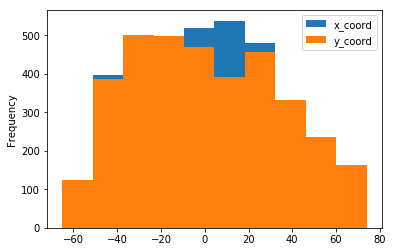

In [52]:
tsne_vectors.plot(kind = 'hist')

In [53]:
tsne_vectors['word'] = tsne_vectors.index

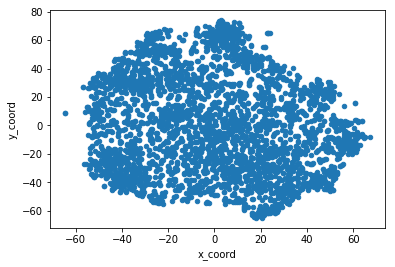

In [54]:
tsne_vectors.plot(kind = 'scatter', x = 'x_coord', y = 'y_coord')

In [55]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value
from bokeh.io.export import file_html

output_notebook()

Loading BokehJS ...

In [56]:
# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(tsne_vectors)

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'),
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@word') )

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=plot_data,
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);

# UMAP clustering

In [57]:
umap_filepath = '../models/te_ara_umap.model'
umap_vectors_filepath = '../models/umap_vectors.npy'

In [58]:
%%time

if from_scratch or not os.path.exists(umap_filepath):
    
    umap = UMAP()
    umap_vectors = umap.fit_transform(dist_matrix.values)
    
    with open(umap_filepath, 'wb') as f:
        pickle.dump(umap, f)

    pd.np.save(umap_vectors_filepath, umap_vectors)

else:
    with open(umap_filepath, 'rb') as f:
        tsne = pickle.load(f)

umap_vectors = pd.np.load(umap_vectors_filepath)

umap_vectors = pd.DataFrame(umap_vectors,
                            index=pd.Index(dist_matrix.index),
                            columns=[u'x_coord', u'y_coord'])

umap_vectors['word'] = umap_vectors.index

CPU times: user 15.9 s, sys: 2.47 s, total: 18.4 s
Wall time: 14.5 s


In [59]:
umap_vectors.reset_index(drop=True).to_csv("../data/umap.csv", index = False)

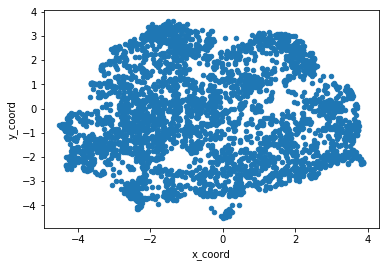

In [60]:
umap_vectors.plot(kind = 'scatter', x = 'x_coord', y = 'y_coord')

In [65]:
# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(umap_vectors)

# create the plot and configure the
# title, dimensions, and tools
umap_plot = figure(title=u'UMAP Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'),
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
umap_plot.add_tools( HoverTool(tooltips = u'@word') )

# draw the words as circles on the plot
umap_plot.circle(u'x_coord', u'y_coord', source=plot_data,
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
umap_plot.title.text_font_size = value(u'16pt')
umap_plot.xaxis.visible = False
umap_plot.yaxis.visible = False
umap_plot.grid.grid_line_color = None
umap_plot.outline_line_color = None

# engage!
show(umap_plot);